## FINAL PROJECT
Frederik Kallestrup Mastratis (qln174)  
Dongyu Liu (dlf327)  
Shamim Tariq Akram (zmx145)  
Celina Aurora Nguyen (szf345)  

Group 21

## PACKAGES

In [41]:
import numpy as np
import pandas as pd
import re
import datefinder
import requests
import random

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import psycopg2

from cleantext import clean
from bs4 import BeautifulSoup as bs


In [2]:
df_test = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv", delimiter=",")

## TEXT CLEANER

In [3]:
DATE = '3[01]|[12][0-9]|0?[1-9]'
DATE_SUFFIXES = 'st|th|rd|nd'
DAY = '(mon|tues|thurs|fri|sun)(day)?|wed(nesday)?|sat(urday)?'
YEAR = '([12][0-9])?[0-9]{2}'
MONTHS = 'jan\.?(uary)?|feb\.?(ruary)?|mar\.?(ch)?|apr\.?(il)?|may|jun\.?(e)?|jul\.?(y)?|aug\.?(ust)?|sep\.?(tember)?|oct\.?(ober)?|nov\.?(ember)?|dec\.?(ember)?'

# format: pretty much all digit formats DD/MM/YY etc.
fd1 = '((%s)\s,?)?\d{1,4}[\\/-]\d{1,2}[\\/-]\d{1,4}' % (DAY)
# format: DD-DD MON (YYYY)
fd2 = '((%s)\s,?)?(%s)(%s)?(\s?-\s?(%s))?\s(%s)(\s?,?\s(%s))?' % (DAY, DATE, DATE_SUFFIXES, DATE, MONTHS, YEAR)
# format: MON DD-DD (YYYY)
fd3 = '((%s)\s,?)?(%s)\s(%s)(%s)?(\s?-\s?(%s))?(\s?,?\s(%s))?' % (DAY, MONTHS, DATE, DATE_SUFFIXES, DATE, YEAR)
# format: MON YYYY
fd4 = '(%s)\s(%s)?' % (MONTHS, YEAR)

DATES_REGEX = re.compile(r"(%s)|(%s)|(%s)|(%s)" % (fd1, fd2, fd3, fd4))

def clean_text(txt):
    txt = txt.lower()

    txt = re.sub(r"\s+", " ", txt)
    regex = {" EMAIL " : r"\w+@\w+(\.[a-z]{2})?\.[a-z]{2,3}",
        " URL " : r"([a-z\d]+://)?[a-z]+[a-z\d]*(\.[a-z\d\-\._~]+)+(/[a-z\d\-\._~]*|(\?[a-z\d\-\._~]+=[a-z\d\-\._~]+))*",
        " DATE " : DATES_REGEX,
        " NUM " : r"[+-]?((\d+(,|\.))*\d+)"}

    for k in regex.keys():
      txt = re.sub(regex[k], k, txt)

    txt = re.sub(r"/", "", txt)

    # Extra cleaning with cleantext library
    txt = clean(txt,
      lower=False,
      normalize_whitespace=True,
      no_line_breaks=True,
      strip_lines=True,
      no_numbers=True, replace_with_number= ' NUM ',
      no_urls=True, replace_with_url=' URL ',
      no_emails=True, replace_with_email=' EMAIL ',
      no_punct=True, replace_with_punct=''
    )

    tokens = word_tokenize(txt)
    prepostfix = lambda t: "<"+t+">" if t.isupper() else t
    tokens = list(map(prepostfix, tokens))

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    stemmer = SnowballStemmer(language='english')
    tokens = [stemmer.stem(w) if w[0] != '<' else w for w in tokens]
    
    return tokens

In [4]:
##lemmatize
def tokenize_mood(txt):
  tokens = nltk.sent_tokenize(txt)
  prepostfix = lambda t: "<"+t+">" if t.isupper() else t
  return map(lambda sentence: map(prepostfix, sentence), tokens)

def mood_mapper(mood):
  if mood.startswith('J'):
        return wordnet.ADJ
  elif mood.startswith('V'):
        return wordnet.VERB
  elif mood.startswith('N'):
        return wordnet.NOUN
  elif mood.startswith('R'):
        return wordnet.ADV
  else:          
        return None

def Lemm(tokenss):
  lemmatize = WordNetLemmatizer().lemmatize
  stop_words = set(stopwords.words('english'))
  tss = map(lambda ts: map(lambda t: (t[0], mood_mapper(t[1]))), tokenss)
  lemmatized = []
  for ts in tss:
    for word, mood in ts:
      w = word if mood is None else lemmatize(word, mood)
      if not w in stop_words: 
        lemmatized.append(w)
  return lemmatized

In [5]:
df_test = df_test.dropna(subset =["type"])

df_content = df_test["content"]
df_tokens = df_content.apply(clean_text)

df_test["tokens"] = df_tokens
df_cleaned = df_tokens.apply(lambda x: ' '.join(x))
df_test["cleaned_content"] = df_cleaned

df_cleaned.to_csv('testclean.csv')

## Observations

1. **Length by article type (*type_token_relation*):** 
This boxplot gives the distribution of the length of the articles in tokens within article types. Taking into consideration that the supermajority of articles types are undersamples in the data set (<6) (observation 2) this observation does not make it seem likely that there is a useful correlation between length and type.  
2. **URL token frequency by article type (*type_URLfreq_relation*):**
This boxplot gives the distribution of the frequency of the URL token within article type. It shows that many types are undersampled. This motivated us to look at the criteria for the types in the FakeNewsCorpus; aritcle types are mutually exclusive, but their semantics are not. This begs the question how FakeNews corpus decides when multiple types are appropriate - it seems that they have som rank-order for which type takes precedens, though as observation 4 shows this cannot be concluded.  
3. **Distribution of types (*type_distribution*):**
This barplot shows the distribution of types. From it we can conclude that the data(sub)set has an exponential drop-off in how populated each types is. Since we only have about 250 articles this means that the less populated types are very undersampled.
4. **Distribution of types within a domain(*domain_type_relation*)**
Most interestingly this oberservation shows us that each domain only have one type associated with them. This means that we have to be careful about what our model is actually checking; it could be that it is only checking the domain (through inference by the structure of the tokens) and then guesses by the type associated with the domain. It also shows that the datasubset have very few articles associated for each domain (<3).

In [7]:
# Function which returns list of token counts [URL, NUM, DATA, EMAIL, ALL_tokens]
def count_tokens(tokens):
    meta_tokens  = ["<URL>", "<NUM>", "<DATE>", "<EMAIL>"]
    meta_counts = [0, 0, 0, 0]
    for token in tokens:
      if token in meta_tokens:
        i = meta_tokens.index(token)
        meta_counts[i] += 1
    token_count = len(tokens)
    return [token_count] + meta_counts


# Observation 1 - relationship between type and tokencount (length of article)
def type_token_relation(df):
    counts = df["tokens"].apply(count_tokens)
    tokens = counts.apply(lambda xs: xs[0])
    tokens = tokens.rename("token_count")
    df_temp = pd.concat([df["type"], tokens], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["token_count"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 2 - relationship between type and URL frequency
def type_URLfreq_relation(df):
    counts = df["tokens"].apply(count_tokens)
    url_freq = counts.apply(lambda xs: xs[1]/xs[0])
    url_freq = url_freq.rename("url_freq")
    df_temp = pd.concat([df["type"], url_freq], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["url_freq"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 3 - type distribution of dataset
def type_distribution(df):
    df['type'].value_counts().plot.bar()
    return df['type'].value_counts()

# Observation 4 - types of article each domain publishes
def domain_type_relation(df):
    domains = df["domain"].unique()
    types = []
    for domain in domains:
        types.append(df[df["domain"] == domain]["type"].value_counts().to_dict())
    idx = sorted(range(len(types)), key=lambda i: list(types[i].items())[0][1])
    return list(map(lambda i: (domains[i], types[i]), reversed(idx)))

unreliable     181.666667
fake           377.606452
clickbait      163.000000
conspiracy     461.483871
reliable       256.666667
bias           253.833333
hate            32.000000
junksci        219.166667
political      368.260870
unknown       1226.166667
dtype: float64

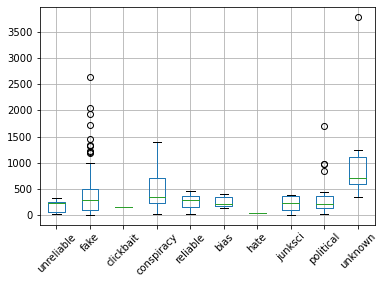

In [8]:
type_token_relation(df_test)

unreliable    0.016894
fake          0.011174
clickbait     0.000000
conspiracy    0.006394
reliable      0.002193
bias          0.012063
hate          0.000000
junksci       0.024873
political     0.006453
unknown       0.003593
dtype: float64

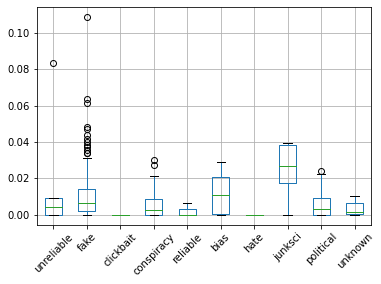

In [9]:
type_URLfreq_relation(df_test)

fake          155
conspiracy     31
political      23
unreliable      6
bias            6
junksci         6
unknown         6
reliable        3
clickbait       1
hate            1
Name: type, dtype: int64

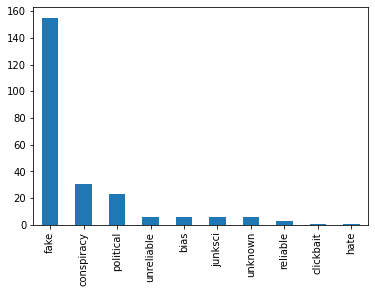

In [10]:
type_distribution(df_test)

In [11]:
domain_type_relation(df_test)

[('beforeitsnews.com', {'fake': 155}),
 ('canadafreepress.com', {'conspiracy': 24}),
 ('washingtonexaminer.com', {'political': 17}),
 ('awarenessact.com', {'conspiracy': 6}),
 ('naturalnews.com', {'junksci': 5}),
 ('strategic-culture.org', {'unknown': 4}),
 ('christianpost.com', {'reliable': 3}),
 ('city-journal.org', {'political': 2}),
 ('vdare.com', {'bias': 2}),
 ('undergroundhealth.com', {'unknown': 2}),
 ('alternet.org', {'political': 2}),
 ('awm.com', {'unreliable': 2}),
 ('breitbart.com', {'political': 1}),
 ('anonhq.com', {'unreliable': 1}),
 ('americanlookout.com', {'bias': 1}),
 ('washingtonsblog.com', {'bias': 1}),
 ('21stcenturywire.com', {'conspiracy': 1}),
 ('unz.com', {'bias': 1}),
 ('nationalreview.com', {'political': 1}),
 ('collectivelyconscious.net', {'junksci': 1}),
 ('breakpoint.org', {'unreliable': 1}),
 ('barenakedislam.com', {'hate': 1}),
 ('charismanews.com', {'bias': 1}),
 ('blackagendareport.com', {'unreliable': 1}),
 ('bipartisanreport.com', {'clickbait': 1}

## WIKINEWS SCRAPER

In [12]:
def create_soup(url):
    site = requests.get(url)
    return bs(site.text, "html.parser")

soup = create_soup('https://en.wikinews.org/wiki/Category:Politics_and_conflicts')

assigned_letters = "ABCDEFGHIJKLMNOPRSTUVWZABCDEFGHIJKLMNOPRSTUVWZ"[21%23:21%23+10]

In [13]:
def valid_links(soup):
    links=[]
    def is_valid(tag):
        return tag.name == 'a' and tag.get('title')[0] in assigned_letters
    section = {'id':"mw-pages"}
    subsection = {'class':"mw-category mw-category-columns"}
    for link in soup.find('div', section).find('div', subsection).find_all(is_valid):
        links.append("https://en.wikinews.org" + link.get('href'))
    return links

def next_page_url(soup):
    return "https://en.wikinews.org" + soup.find('a', string="next page").get('href')
    
def no_more_pages(soup):
    return soup.find('a', string="next page") is None

def get_links(soup, links):
    links += valid_links(soup)

    if no_more_pages(soup):
        return links
    else:
        next_soup = create_soup(next_page_url(soup))
        return get_links(next_soup, links)
    

In [14]:
links = get_links(soup, [])
len(links)

3085

In [15]:
def content_parser(soup):
    publish_date = ""
    content = ""

    terminators = ('Have an opinion on this story', 'Share this', 'This article has passed through community review',
        'This page is archived')

    for tag in soup.find('div', {'id':"bodyContent"}).find('div', {'class':"mw-parser-output"}).find_all(['p','dl']):
        datetag = tag.find('strong', {'class': "published"})
        
        if tag.text.startswith(terminators):
            break
        elif datetag != None:
            publish_date = datetag.span['title']
            content += tag.text
            content = content[len(datetag.text):] 
        else:
            content += (tag.text + "\n")
    
    return content, publish_date

def footer_parser(soup):
    modified_date = ""
    modified_tag = soup.find('li', {'id':"footer-info-lastmod"})
    if modified_tag != None:
        modified_text = modified_tag.text
        dates_from_text = list(datefinder.find_dates(modified_text))
        if len(dates_from_text) > 0:
            modified_date = dates_from_text[0].strftime('%Y-%m-%d')
    
    return modified_date

def source_parser(soup):
    sources = []
    for tag in soup.find_all('span', {'class':"sourceTemplate"}):
        source_text = tag.find('i')
        if source_text != None:
            sources.append(source_text.text)
    
    return sources

def categories_parser(soup):
    categories = []

    # Remove common categories
    excluded = ['','Published', 'Archived', 'Politics and conflicts']

    for tag in soup.find('div', {'id':"mw-normal-catlinks"}).find_all('li'):
        if tag.text not in excluded:
            categories.append(tag.text)
    
    # Remove date category
    if len(list(datefinder.find_dates(categories[0]))) > 0:
        categories = categories[1:]

    return categories
    

def scrape(url):
    soup = create_soup(url)

    title = soup.find('h1', {'id':"firstHeading"}).text

    content, publish_date = content_parser(soup)

    modified_date = footer_parser(soup)

    sources = source_parser(soup)

    categories = categories_parser(soup)

    return title, publish_date, modified_date, sources, categories, content

In [16]:
#scraped_data = pd.DataFrame(map(scrape, links), columns = ['title', 'publish_date', 'modified_date', 'sources', 'categories', 'content'])

In [17]:
#scraped_data.to_csv('wikinews.csv', encoding='utf-8')

## DATABASE FAKENEWS CORPUS

In [18]:
# df_rand = pd.read_csv(
#     "1mio-raw.csv", 
#     delimiter = ",",
#     header = 0, 
#     skiprows = lambda x: x > 0 and random.random() > 0.1
# )

c:\Users\Theo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
#df_rand.to_csv('100krandFNC.csv', index = False)

#df_rand.shape[0]

100494

In [21]:
# Splits a string into list
def string_splitter(string):
    #if type(string) != str: 
    lst = str(string).split(", ")
    filter_obj = filter(lambda x: x != "", lst)
    return list(filter_obj)

# Strip a string representation of list of strings
def string_stripper(string):
    lst = [i.strip() for i in string[1:-1].replace('\'',"").split(',')]
    filter_obj = filter(lambda x: x != "", lst)
    return list(filter_obj)

def string_filter(lst):
    filters = [lambda x: not x.isdigit(), lambda x: x != ""]
    filter_obj = filter(lambda x: all([f(x) for f in filters]), lst)
    return list(filter_obj)

In [50]:
df_fnc = pd.read_csv('100krandFNC.csv')

# Dropping columns (setting new ID column later)
df_fnc = df_fnc.drop(columns = ['Unnamed: 0', 'id', 'source'])

# Set new ID column
df_fnc = df_fnc.rename_axis('id').reset_index()
df_fnc.set_index('id')

df_fnc = df_fnc.astype({'domain':str, 'type':str, 'url':str, 'content':str, 'scraped_at':str, 'inserted_at':str,
        'updated_at':str, 'title':str, 'authors':str, 'keywords':str, 'meta_keywords':str,
        'meta_description':str, 'tags':str, 'summary':str}, copy = False)

# Convert blank fields into NaN
#df = df.replace(r'^\s*$', np.nan, regex=True)

# Replace 'nan' strings with NaN
df_fnc = df_fnc.replace("nan", np.nan)

# Convert all strings into lower case:
df_fnc = df_fnc.applymap(lambda s: s.lower() if type(s) == str else s)

# Clean types
type_set = ['fake', 'satire', 'bias', 'conspiracy', 'state', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable','rumor']
df_fnc['type'] = df_fnc['type'].apply(lambda x: np.nan if x not in type_set else x)

# Clean timestamps
for column in ['scraped_at','inserted_at','updated_at']:
    df_fnc[column] = df_fnc[column].apply(lambda x: pd.to_datetime(x, errors='coerce'))
    df_fnc[column] = df_fnc[column].replace({np.NaN: None})

# Clean auhtors - separate into list of strings
df_fnc['authors'] = df_fnc['authors'].apply(lambda x: string_splitter(x) if pd.notnull(x) else x)

# Clean metakeywords - strip a string representation of list of strings
df_fnc['meta_keywords'] = df_fnc['meta_keywords'].apply(lambda x: string_stripper(x) if pd.notnull(x) else x)

# Clean tags
df_fnc['tags'] = df_fnc['tags'].apply(lambda x: string_splitter(x) if pd.notnull(x) else x)
df_fnc['tags'] = df_fnc['tags'].apply(lambda x: string_filter(x) if isinstance(x, list) else x)

# Replace NaN into empty lists
for column in ['authors', 'keywords', 'meta_keywords', 'tags']:
    df_fnc[column] = df_fnc[column].fillna("").apply(list)

# Remove empty rows
df_fnc = df_fnc.dropna(subset = ['title', 'content', 'type'], how = 'all')

c:\Users\Theo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
df_fnc.to_csv('test.csv', index=False)
display(df_fnc)

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,blackagendareport.com,unreliable,https://blackagendareport.com/articlelist/inte...,it should have come as no surprise that the sa...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,black agenda report,"[nellie bailey, glen ford, margaret kimberley,...",[],[],NaN,[],NaN
1,1,blackgenocide.org,conspiracy,http://blackgenocide.org/events_2017.html,\n\n\n\n\n\n\n\nrev dr. childress is available...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,blackgenocide.org,[],[],"[pro-life events, clenard childress, schedule,...",find out when and where you can get involved w...,[],NaN
2,2,blackgenocide.org,conspiracy,http://blackgenocide.org/speaking_request.html,\n\nspeaking engagement request\n\n\n\ncontact...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,request speaking engagement,[],[],[],NaN,[],NaN
3,3,blackgenocide.org,conspiracy,http://blackgenocide.org/archived_articles/neg...,"""…i have set before you life and death, blessi...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,blackgenocide.org,[],[],"[planned parenthood, minorities, black culture...",the negro project is a devastating eugenic sta...,[],NaN
4,4,awm.com,unreliable,http://awm.com/woman-waves-hand-in-front-of-li...,most people’s pets are a member of the family ...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"woman waves hand in front of lizard’s tank, ca...",[wendy michaels],[],[],NaN,[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100489,100489,wikileaks.org,unreliable,https://www.wikileaks.org/plusd/cables/1975acc...,tor\n\ntor is an encrypted anonymising network...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,cable: 1975accra02737,[],[],[],NaN,[view tags],NaN
100490,100490,wikileaks.org,unreliable,https://www.wikileaks.org/plusd/cables/1974cur...,tor\n\ntor is an encrypted anonymising network...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,cable: 1974curaca00430,[],[],[],NaN,[view tags],NaN
100491,100491,wikileaks.org,unreliable,https://www.wikileaks.org/plusd/cables/1976ank...,raw content\n\nconfidential page 01 ankara 019...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,cable: 1976ankara01989,[],[],[],NaN,[view tags],NaN
100492,100492,wikileaks.org,unreliable,https://www.wikileaks.org/plusd/cables/1975bon...,tor\n\ntor is an encrypted anonymising network...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,cable: 1975bonn08156,[],[],[],NaN,[view tags],NaN


In [51]:
#df_fnc[['scraped_at','inserted_at','updated_at']].to_csv('test3.csv')

df_fnc.iloc[11615]

id                                                              11617
domain                                               commondreams.org
type                                                        political
url                 https://www.commondreams.org/news/2016/05/18/o...
content             bernie sanders was able to claim his twentieth...
scraped_at                                 2018-01-25 20:13:50.426130
inserted_at                                2018-02-02 01:19:41.756632
updated_at                                 2018-02-02 01:19:41.756664
title               oregon goes for sanders: "if it's so over, why...
authors                                                            []
keywords                                                           []
meta_keywords       [u.s., bernie sanders, hillary clinton, electi...
meta_description    'let the people in!' declares sanders at rally...
tags                [kentucky, california, election 2016, oregon, ...
summary             

In [24]:
# Generates the tables of our database

fnc_tables = ["fnc_article", "authors", "tags", "keywords", "metakeywords"]

create_fnctables = [
    """ 
    CREATE TABLE fnc_article (
        id INT, 
        domain VARCHAR, 
        type VARCHAR, 
        url VARCHAR, 
        content VARCHAR, 
        scraped_at TIMESTAMP, 
        inserted_at TIMESTAMP,
        updated_at TIMESTAMP, 
        title VARCHAR (256), 
        meta_description VARCHAR, 
        summary VARCHAR,

        PRIMARY KEY (id) 
    );
    """
    ,
    """
    CREATE TABLE authors (
        a_id INT,
        authors VARCHAR,
        PRIMARY KEY (a_id, authors),
        FOREIGN KEY (a_id)
            REFERENCES fnc_article (id)
            ON UPDATE CASCADE ON DELETE CASCADE
    );
    """
    ,
    """ 
    CREATE TABLE tags (
        a_id INT, 
        tag VARCHAR, 
        PRIMARY KEY (a_id, tag),
        FOREIGN KEY (a_id)
            REFERENCES fnc_article (id)
            ON UPDATE CASCADE ON DELETE CASCADE
    );
    """
    ,
    """
    CREATE TABLE keywords (
        a_id INT, 
        keyword VARCHAR,
        PRIMARY KEY (a_id, keyword),
        FOREIGN KEY (a_id)
            REFERENCES fnc_article (id)
            ON UPDATE CASCADE ON DELETE CASCADE
    );
    """
    ,
    """
    CREATE TABLE metakeywords (
        a_id INT, 
        mkeyword VARCHAR,
        PRIMARY KEY (a_id, mkeyword),
        FOREIGN KEY (a_id)
            REFERENCES fnc_article (id)
            ON UPDATE CASCADE ON DELETE CASCADE
    );
    """
]

In [25]:
wn_tables = ["wn_article", "sources", "categories"]

create_wntables = [
    """ 
    CREATE TABLE wn_article (
        id INT, 
        content VARCHAR, 
        publish_date TIMESTAMP, 
        modified_date TIMESTAMP,
        title VARCHAR (256), 

        PRIMARY KEY (id) 
    );
    """
    ,
    """
    CREATE TABLE sources (
        a_id INT,
        sources VARCHAR,
        PRIMARY KEY (a_id, sources),
        FOREIGN KEY (a_id)
            REFERENCES wn_article (id)
            ON UPDATE CASCADE ON DELETE CASCADE
    );
    """
    ,
    """ 
    CREATE TABLE categories (
        a_id INT, 
        categories VARCHAR, 
        PRIMARY KEY (a_id, categories),
        FOREIGN KEY (a_id)
            REFERENCES wn_article (id)
            ON UPDATE CASCADE ON DELETE CASCADE
    );
    """
]

In [52]:
# FOR TAs please configure this with your own settings

conn = psycopg2.connect(dbname="fakenewsdb", user="postgres", password="1234")

cursor = conn.cursor()

for table in fnc_tables:
    cursor.execute("DROP TABLE IF EXISTS " + table + " CASCADE;")

for sql in create_fnctables:
    cursor.execute(sql)

conn.commit

<function connection.commit>

In [27]:
# Set of functions that puts the data from pd.dataframe into the right tables. Explodes the dataframe columns with
# list of strings into seperate entries each with their own key (a_id, string)

def projectrow2tuple(fields, row):
    return tuple(map(lambda f: row[f], fields))

def insertstring(table, n):
    return "INSERT INTO {} VALUES ({}) ON CONFLICT DO NOTHING".format(table, ", ".join(map(lambda _: '%s', range(n))))

def multi_insert(server, a_id, insert, xs):
    for x in xs:
        server.execute(insert, (a_id, x))

In [53]:
def insert_csv2rows_fnc(server, csv_row):
    A_domain = ['id', 'domain', 'type', 'url', 'content', 'scraped_at',
       'inserted_at', 'updated_at', 'title', 'meta_description', 'summary']
    AU_domain = ['id', 'authors']
    T_domain = ['id', 'tags']
    K_domain = ['id', 'keywords']
    MK_domain = ['id', 'meta_keywords']
    
    Atuple = projectrow2tuple(A_domain, csv_row)
    (a_id, tags) = projectrow2tuple(T_domain, csv_row)
    (_, au) = projectrow2tuple(AU_domain, csv_row)
    (_, kws) = projectrow2tuple(K_domain, csv_row)
    (_, mkws) = projectrow2tuple(MK_domain, csv_row)

    Ainsert = insertstring("fnc_article", len(Atuple))
    Tinsert = insertstring("tags", 2)
    AUinsert = insertstring("authors", 2)
    Kinsert = insertstring("keywords", 2)
    MKinsert = insertstring("metakeywords", 2)

    server.execute(Ainsert, Atuple)
    insert = lambda ins, xs: multi_insert(server, a_id, ins, xs)
    insert(Tinsert, tags)
    insert(AUinsert, au)
    insert(Kinsert, kws)
    insert(MKinsert, mkws)


for _, row in df_fnc.iterrows():
    insert_csv2rows_fnc(cursor, row)

conn.commit

<function connection.commit>

## QUERIES

In [ ]:
# QUERY 1

query1 = """
    SELECT distinct domain, type, scraped_at 
    FROM article
    WHERE type = 'reliable' AND scraped_at >= '2018-01-15'
"""

cursor.execute('rollback')
cursor.execute(query1)
cursor.fetchall()

In [ ]:
# QUERY 2

query2 = """
    SELECT authors
    FROM (
        SELECT COUNT(a_id) AS cnt, authors 
        FROM authors 
        WHERE a_id IN (
            SELECT id
            FROM article
            WHERE type = 'fake'
        ) 
        GROUP BY authors
    ) AS x
    WHERE cnt = (SELECT MAX(cnt) FROM x)
"""

# This gives a max, but doesnt take into account if multiple authors write max number of fake articles
query2_pseudomax = """
    SELECT COUNT(a_id), authors 
    FROM authors 
    WHERE a_id IN (
        SELECT id
        FROM article
        WHERE type = 'fake'
    )
    GROUP BY authors ORDER BY COUNT(a_id) DESC LIMIT 1
"""

cursor.execute('rollback')
cursor.execute(query2_pseudomax)
cursor.fetchall()

In [ ]:
# QUERY 3 - Need to join the metakeywords table on id and concatenate a single strings with keywords sorted in alphabetical order
# then we can use that to compare with other entries in the tables - Didnt have time to finish

query3 = """
    SELECT a_id, COUNT(*)
    FROM metakeywords
    GROUP BY a_id, mkeyword
    HAVING COUNT(*) > 1
"""

cursor.execute('rollback')
cursor.execute(query3)
cursor.fetchall()

In [ ]:
# QUERY 1 - FINDING THE TOP 3 DOMAIN PUBLISHING THE MOST FAKE ARTICLES
q1 = """
    SELECT COUNT(id), domain
    FROM article
    WHERE id IN (
        SELECT id
        FROM article
        WHERE type = 'fake'
    )
    GROUP BY domain ORDER BY COUNT(id) DESC LIMIT 3
"""

cursor.execute('rollback')
cursor.execute(q1)
cursor.fetchall()

In [ ]:
# QUERY 2 - WHICH TYPE OF ARTICLES IS DONALD TRUMP MOST OFTEN MENTIONED IN

q2 = """
    SELECT COUNT(id), type
    FROM (
      SELECT id, type, domain
      FROM artikel
      WHERE title LIKE '%trump%'
    ) as x
    GROUP BY type  ORDER BY COUNT(id) DESC LIMIT 3
"""

cursor.execute('rollback')
cursor.execute(q2)
cursor.fetchall()

In [121]:
# Dataset for model

query_fnc = """
    SELECT id, type, content
    FROM fnc_article
"""

df_fncpull = pd.read_sql(query_fnc, conn)

In [114]:
df_fncpull

df_fncpull['type'].value_counts()

political     29296
unreliable    14022
bias          13844
fake          12409
conspiracy    11045
NaN            8926
rumor          4645
clickbait      2103
junksci        1681
satire         1471
reliable        677
hate            367
Name: type, dtype: int64

In [122]:
type_real = ['political', 'reliable']
type_fake = ['fake', 'satire', 'bias', 'conspiracy', 'junksci', 'hate']
type_inbetween = ['clickbait', 'unreliable']

def type_classifier(type):
    if type in type_real:
        type = 1
    elif type in type_fake:
        type = 0

    return type

In [123]:
df_fncpull = df_fncpull[df_fncpull['type'].isin(type_real + type_fake)]

df_fncpull['type'] = df_fncpull['type'].apply(type_classifier)

df_fncpull['type'].value_counts()

0    40817
1    29973
Name: type, dtype: int64

In [124]:
df_fnccontent = df_fncpull["content"]
df_fnctokens = df_fnccontent.apply(clean_text)

df_fnccleaned = df_fnctokens.apply(lambda x: ' '.join(x))
df_fncpull["content"] = df_fnccleaned

df_fncpull.to_csv('fncpullcleaned.csv', index = False)

KeyboardInterrupt: 

In [ ]:
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,1), token_pattern=r"(?u)\b\w\w+\b|<DATE>|<NUM>|<EMAIL>|<URL>")

X = vectorizer.fit_transform(df_cleaned).toarray()

features = vectorizer.get_feature_names()

_list = features
textfile = open("features.txt", "w")
for element in _list:
    textfile.write(element + "\n")
textfile.close()